<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!poetry add transformers

The following packages are already present in the pyproject.toml and will be skipped:

  • transformers

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [2]:
!poetry add datasets jiwer

The following packages are already present in the pyproject.toml and will be skipped:

  • datasets
  • jiwer

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [3]:
import pandas as pd

df = pd.read_csv('./tibetan-dataset/labels_new.csv', sep=',', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
# some file names end with jp instead of jpg, let's fix this
df.head()

,file_name,text
0,ImageName,Text
1,1-1-100a_line_9874_0.jpg,།གསལ་དང་འཛིན་འཇུག་དང༌། །སློབ་དང་སློབ་འཇུག་རྣམ་...
2,1-1-100a_line_9874_1.jpg,འཆའ་འཆར་གཞུག་ལྟུང་བ་ཤེས། །ལྷོ་ཡི་རི་ལ་རྒྱུ་བ་ཡ...
3,1-1-100a_line_9874_2.jpg,མ་ལོན་པའོ། །སངས་རྒྱས་བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་རྒ...
4,1-1-100a_line_9874_3.jpg,བ་མི་མཁས་པ་ཞིག་གིས་གཞན་མུ་སྟེགས་ཅན་ཞིག་རབ་ཏུ་ཕ...


We split up the data into training + testing, using sklearn's `train_test_split` function.

In [4]:
# check if a specific file name exists in df['file_name']
df['file_name'].str.contains('20-1-59b_line_9874_3.jpg').any()

False

In [5]:
# # delete all the files that are not in file_name anymore
# import os
# for file_name in os.listdir('./tibetan-dataset/train/'):
#     if file_name not in df['file_name'].values:
#         os.remove('./tibetan-dataset/train/' + file_name)
#         print(file_name)

In [6]:
# # modify the csv file to only contain the file names that are still in the folder
# list_to_delete = "20-1-59b_line_9874_3.jpg,20-1-59b_line_9874_4.jpg,20-1-59b_line_9874_5.jpg,20-1-59b_line_9874_6.jpg,20-1-5a_line_9874_0.jpg,20-1-5a_line_9874_2.jpg,20-1-5a_line_9874_3.jpg,20-1-5a_line_9874_4.jpg,20-1-5a_line_9874_5.jpg,20-1-5a_line_9874_6.jpg,20-1-5b_line_9874_1.jpg,96-1-329b_line_9874_4.jpg,96-1-32a_line_9874_0.jpg,96-1-32a_line_9874_1.jpg,96-1-32a_line_9874_3.jpg,96-1-32a_line_9874_4.jpg,96-1-32a_line_9874_5.jpg,96-1-32a_line_9874_6.jpg".split(',')
# 
# for file_name in list_to_delete:
#     df = df[df['file_name'] != file_name]
# # modify the csv file
# df.to_csv('./tibetan-dataset/labels_new.csv', header=False, index=False)

In [7]:
# from PIL import Image
# for i in df['file_name']:
#     try:
#         Image.open('./tibetan-dataset/train/' + i).convert("RGB")
#     except Exception as ex:
#         print(i)
#         print(ex)

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

In [9]:
import torch
from torch.utils.data import Dataset


class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=512):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [10]:
encode, decode = "google/vit-base-patch16-224-in21k", "sangjeedondrub/tibetan-roberta-base"

Let's initialize the training and evaluation datasets:

In [11]:
from transformers import TrOCRProcessor, ViTImageProcessor, RobertaTokenizer

feature_extractor=ViTImageProcessor.from_pretrained(encode)
tokenizer = RobertaTokenizer.from_pretrained(decode)
print(tokenizer.vocab_size)
processor = TrOCRProcessor(image_processor=feature_extractor, tokenizer=tokenizer)
train_dataset = IAMDataset(root_dir='./tibetan-dataset/train/',
                           df=train_df[:len(train_df)],
                           processor=processor)
eval_dataset = IAMDataset(root_dir='./tibetan-dataset/train/',
                           df=test_df[:len(test_df)],
                           processor=processor)

22869


In [12]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 359194
Number of validation examples: 89799


Let's verify an example from the training dataset:

In [13]:
from PIL import Image
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([512])


We can also check the original image and decode the labels:

In [14]:
train_df['file_name'][0]

'I3CN50350042_16.tif'

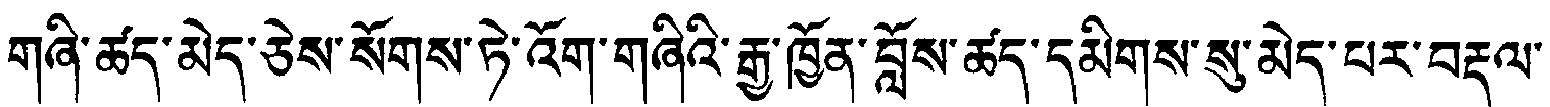

In [15]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [16]:
# for i in train_df['file_name']:
#     try:
#         Image.open(train_dataset.root_dir + i).convert("RGB")
#     except Exception as ex:
#         print(i)
#         print(ex)

In [17]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

གཞི་ཚད་མེད་ཅེས་སོགས་ཏེ་འོག་གཞིའི་རྒྱ་ཁྱོན་བློས་ཚད་དམིགས་སུ་མེད་པར་བརྡལ་


In [18]:
# from all the file names find out which ones don't exist in train folder
# import os
# my_list = os.listdir('./tibetan-dataset/train/')
# for i, file_name in enumerate(df['file_name']):
#     if file_name not in my_list:
#         print(file_name)
#     else:
#         # use index to remove the file name from my_list
#         my_list.remove(file_name)
#         print(len(my_list))

Let's create corresponding dataloaders:

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr). 

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [19]:

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [20]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encode, decode)

model.to(device)

assert model.config.decoder.is_decoder is True
assert model.config.decoder.add_cross_attention is True

cuda


C:\Users\301212298\AppData\Local\pypoetry\Cache\virtualenvs\trocr-tibetan-fine-tuning--TNO-9cB-py3.10\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at sangjeedondrub/tibetan-roberta-base and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.enco

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [21]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 512
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.5
model.config.num_beams = 4


We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [22]:
from datasets import load_metric

cer_metric = load_metric("cer")

C:\Users\301212298\AppData\Local\Temp\ipykernel_33276\910432076.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
C:\Users\301212298\AppData\Local\pypoetry\Cache\virtualenvs\trocr-tibetan-fine-tuning--TNO-9cB-py3.10\lib\site-packages\datasets\load.py:753: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [23]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

for epoch in range(10):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained("test")

  0%|          | 0/89799 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.